# FINM 25000 - Quantitative Portfolio Management and Algorithmic Trading
## Homework 2 Solution | Summer 2022

## 2 Analyzing the Data

In [12]:
# Some useful packages and functions

# Import the packages we need

import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define the functions that we need

#Mean, Volatality and Sharpe Ratio
def performanceMetrics(returns,annualization=1, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics


#VaR, CVaR, Max Drawdown
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics


def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
        except:
            summary.loc[col,'Recover'] = pd.to_datetime(None)

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        try:
            summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
        except:
            summary['Duration (to Recover)'] = None
            
        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

    return summary


#Run OLS
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [2]:
# Read the data

#Descriptions sheet. Note the use of .rename to correct column names that are not correctely named in the source file
desc = pd.read_excel('proshares_analysis_data.xlsx','descriptions').rename(columns={'Unnamed: 0':'Symbol'}).set_index('Symbol')

#Hedge Fund Data
hf = pd.read_excel('proshares_analysis_data.xlsx','hedge_fund_series').set_index('date')

#Merrill Lynch Factor Data
mf = pd.read_excel('proshares_analysis_data.xlsx','merrill_factors').set_index('date')

#Other Data
od = pd.read_excel('proshares_analysis_data.xlsx','other_data').set_index('date')

### 1. For the series in the “hedge fund series” tab, report the following summary statistics (annualize these statistics):
#### (a) mean
#### (b) volatility
#### (c) Sharpe ratio

In [10]:
performance_meterics_table = performanceMetrics(hf, annualization=12)
display(performance_meterics_table.style.format\
        (formatter = {'Sharpe' : '{:,.2f}', 'Mean': '{:,.2%}', 'Vol': '{:,.2%}', 'Min': '{:,.2%}', 'Max': '{:,.2%}'}))

,Mean,Vol,Sharpe,Min,Max
HFRIFWI Index,5.08%,6.15%,0.83,-9.08%,5.86%
MLEIFCTR Index,3.88%,5.38%,0.72,-5.32%,5.89%
MLEIFCTX Index,3.73%,5.37%,0.70,-5.24%,5.88%
HDG US Equity,2.81%,5.64%,0.50,-5.92%,5.83%
QAI US Equity,2.55%,4.55%,0.56,-5.63%,3.41%


### 2. For the series in the “hedge fund series” tab, calculate the following statistics related to tail- risk (no need to annualize any of these statistics).
#### (a) Skewness
#### (b) Excess Kurtosis (in excess of 3)
#### (c) VaR (.05) - the fifth quantile of historic returns
#### (d) CVaR (.05) - the mean of the returns at or below the fifth quantile
#### (e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

In [20]:
tail_metrics_table = tailMetrics(hf)
tail_metrics_table['Kurtosis'] = tail_metrics_table['Kurtosis'] - 3
display(tail_metrics_table)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
HFRIFWI Index,-1.109,3.730,-0.025,-0.039,-0.115,2019-12-31,2020-03-31,2020-08-31,244 days
MLEIFCTR Index,-0.187,-0.571,-0.026,-0.033,-0.084,2019-12-31,2020-03-31,2020-11-30,335 days
MLEIFCTX Index,-0.172,-0.624,-0.026,-0.033,-0.084,2019-12-31,2020-03-31,2020-11-30,335 days
HDG US Equity,-0.180,-0.418,-0.029,-0.035,-0.088,2020-01-31,2020-03-31,2020-11-30,304 days
QAI US Equity,-0.545,-0.330,-0.016,-0.026,-0.076,2019-12-31,2020-03-31,2020-07-31,213 days


### 3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics (annualize as necessary):
#### (a) Market Beta
#### (b) Treynor Ratio
#### (c) Information ratio

In [19]:
get_ols_metrics(mf['SPY US Equity'], hf, annualization=12, ignorenan=True)

,alpha,SPY US Equity,r-squared,Treynor Ratio,Info Ratio
HFRIFWI Index,-0.007,0.394,0.753,0.129,-0.242
MLEIFCTR Index,-0.014,0.359,0.816,0.108,-0.615
MLEIFCTX Index,-0.015,0.358,0.815,0.104,-0.671
HDG US Equity,-0.026,0.369,0.786,0.076,-1.011
QAI US Equity,-0.017,0.285,0.719,0.089,-0.687


### 4. Relative Performance
Discuss the previous statistics, and what they tell us about...



#### (a) the differences between SPY and the hedge-fund series?
- Compared to SPY, all hedge fund series have negative alpha (lower mean excess return compared to SPY) and hence negative information ratio (Sharpe of the residual return)
- All series have SPY/market beta near the 0.3-0.4 range, which means they all have a fairly low exposure to the market.
- Given that they have some SPY beta, their total return is positive (Sharpe is positive) but when we strip this factor out, the hedged performance has a negative Sharpe ratio as seen by the Info Ratio (which is the Sharpe Ratio of the hedged position.)



#### (b) which performs better between HDG and QAI.

- HDG has a lower alpha and information ratio, while QAI has a lower beta. 
- However, when beta is adjusted with the beta risk (Treynor ratio), the data shows that HDG has a lower performance.
- Overall, **QAI performs better than HDG**.



#### (c) whether HDG and the ML series capture the most notable properties of HFRI.

- Both HDG and the ML series fail to deliver the same high returns compensated with the high risk of HRFI. 
- The HFRI also shows a very high excess kurtosis, but all of the hedge-fund series has a very small excess kurtosis.





### 5. Report the correlation matrix for these assets.
#### (a) Show the correlations as a heat map.

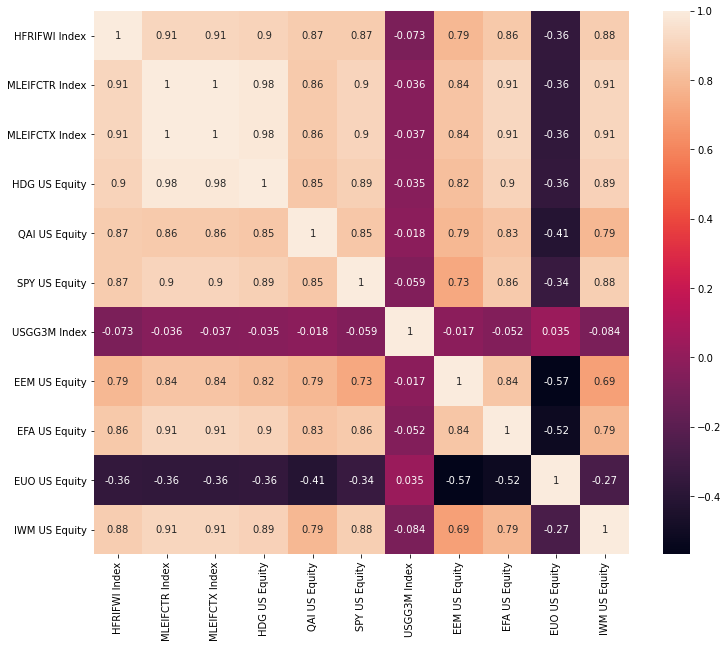

In [25]:
cor_table = pd.concat([hf,mf], axis=1).corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor_table, annot=True)
plt.show()

#### (b) Which series have the highest and lowest correlations?

In [27]:
cor_table = hf.corr()
cor_table[cor_table == 1] = None
cor_table = cor_table.unstack().dropna()
max_cor = cor_table.max()
min_cor = cor_table.min()

print('Strongest correlation is between: '+ str(cor_table[cor_table==max_cor].index[0]))
print('Weakest correlation is between: '+ str(cor_table[cor_table==min_cor].index[0]))

Strongest correlation is between: ('MLEIFCTR Index', 'MLEIFCTX Index')
Weakest correlation is between: ('HDG US Equity', 'QAI US Equity')


### 6. Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression,
$$
\begin{align}
r^{hfri}_t &= \alpha^{merr} + x^{merr}_t\beta^{merr} + \epsilon^{merr}_t \\
\hat{r}^{hfri}_t &\equiv \hat{\alpha}^{merr} + x^{merr}_t\hat{\beta}^{merr}
\end{align}
$$
### Note that the second equation is just our notation for the fitted replication.
#### (a) Report the intercept and betas.

In [63]:
ols_meterics = get_ols_metrics(mf, hf, annualization=12)
names = list(mf.columns)
names.append('alpha')
display(ols_meterics[list(names)])

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,alpha
HFRIFWI Index,0.072,-0.401,0.072,0.106,0.022,0.131,0.014
MLEIFCTR Index,0.039,0.536,0.069,0.140,0.036,0.112,0.001
MLEIFCTX Index,0.037,0.510,0.069,0.140,0.036,0.111,-0.000
HDG US Equity,0.041,0.575,0.066,0.144,0.035,0.116,-0.011
QAI US Equity,0.142,0.568,0.067,0.049,-0.003,0.024,-0.008


#### (b) Are the betas realistic position sizes, or do they require huge long-short positions?

The betas shows large positions in USGGM3M index, sometimes it's beta is more than 10 times the beta of SPY. But that's also because USGGM3M has lower volatality, so if we standardize betas by volatality, we see that the beta are similar and so the position sizes are realistic. Below calculation supports this argument

In [70]:
vol = np.array(performanceMetrics(mf)['Vol'])
beta = np.array(ols_meterics.loc['HFRIFWI Index'][list(mf.columns)])
beta_weights = beta*vol
print(beta_weights)

[ 0.00281434 -0.0002661   0.00381874  0.00451249  0.00101261  0.00708819]


#### (c) Report the R-squared.

In [73]:
display(pd.DataFrame(ols_meterics['r-squared']).style.format('{:,.2%}'))

,r-squared
HFRIFWI Index,85.57%
MLEIFCTR Index,94.84%
MLEIFCTX Index,94.80%
HDG US Equity,91.02%
QAI US Equity,78.82%


#### (d) Report the volatility of $\epsilon^{merr}$ (the tracking error).

In [75]:
display(pd.DataFrame(ols_meterics.alpha/ols_meterics['Info Ratio']).style.format('{:,.2%}'))

,0
HFRIFWI Index,2.34%
MLEIFCTR Index,1.22%
MLEIFCTX Index,1.22%
HDG US Equity,1.69%
QAI US Equity,2.09%
